# Document Image Classification using Transfer Learning from VGG16  (pretrained with ImageNet dataset)

This exercise classifies document image files, using pre-trained ConvNet VGG16. The project was conducted on private dataset. Print output is removed to protect provicy. 


### Reference:

Binary class image recognition using Transfer Learning:
https://blog.keras.io/
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

Multi-class image recognition using Transfer Learning:
https://www.codesofinterest.com/2017/08/bottleneck-features-multi-class-classification-keras.html

Graph Model Traning History in Keras:
https://www.codesofinterest.com/2017/03/graph-model-training-history-keras.html


## Transfer Learning

Transfer learning has become popular recently in computer vision, when there is not enough labled data to train a full neural network. It is observed that the lower layers of a neural network (such as CNN) are responsible to automatically extract basic visual features such as lines and shapes etc, thus a pre-trained NN can be "transferred" to recogenize different images with higher layers re-trained on the intented images.  

In [2]:
#Using Bottleneck Features for Multi-Class Classification in Keras

import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import math
#import cv2

/anaconda/envs/keras2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Dataset 

Dataset is pre-split into training and valiation, that are under directory "data/train" and "data/validation" corespondingly

In [3]:

# dimensions of our images when loading.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'data/Document_PNG/train'
validation_data_dir = 'data/Document_PNG/validation'

# number of epochs to train top model
epochs = 50
# batch size used by flow_from_directory and predict_generator
batch_size = 16


The basic technique of transfer learning is to get a pre-trained model (with the weights loaded) and remove final fully-connected layers from that model. We then use the remaining portion of the model as a feature extractor for our smaller dataset. These extracted features are called "Bottleneck Features". Then train the last fully-connected network block on those extracted bottleneck features in order to get the classes we need as outputs for our problem.

<img src="VGG16.png">

The data is split into training and validation. In each of training and validation directory, the class (category) should be used as sub-directory name. Under each sub-directory, there are the image files that belongs to that class.

In [4]:
def create_generator(root_path):
    datagen = ImageDataGenerator(rescale=1. / 255)

    generator = datagen.flow_from_directory(
        root_path,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    # Comment out print statement to protect privacy
    #generator.filenames contains all the filenames
    #print('total number of samples = {0}'.format(len(generator.filenames)))
    
    # generator.class_indices is the map/dictionary for the class-names and their indexes
    #print('number of categories= {0}'.format(len(generator.class_indices)))
    
    #print('\ncategory vs. index mapping:')
    #print(generator.class_indices)
    
    return generator
    

In [5]:
train_generator = create_generator(train_data_dir)

Found 577 images belonging to 17 classes.


In [6]:
 
validation_generator = create_generator(validation_data_dir)

Found 64 images belonging to 17 classes.


In [6]:
def save_bottlebeck_features(train_generator, validation_generator):
    
    # build the VGG16 network, use the weights trained on imagenet data
    model = applications.VGG16(include_top=False, weights='imagenet')


    nb_train_samples = len(train_generator.filenames)
    num_classes = len(train_generator.class_indices)

    predict_size_train = int(math.ceil(nb_train_samples / batch_size))

    bottleneck_features_train = model.predict_generator(
        train_generator, predict_size_train)

    np.save('bottleneck_features_train.npy', bottleneck_features_train)

   
    nb_validation_samples = len(validation_generator.filenames)

    predict_size_validation = int(
        math.ceil(nb_validation_samples / batch_size))

    bottleneck_features_validation = model.predict_generator(
        validation_generator, predict_size_validation)

    np.save('bottleneck_features_validation.npy',
            bottleneck_features_validation)






In [7]:
save_bottlebeck_features(train_generator, validation_generator)


/anaconda/envs/keras2/lib/python3.6/site-packages/PIL/Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [8]:
def train_FC_model():
    datagen_top = ImageDataGenerator(rescale=1. / 255)
    generator_top = datagen_top.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

    nb_train_samples = len(generator_top.filenames)
    num_classes = len(generator_top.class_indices)

    # save the class indices to use use later in predictions
    np.save('class_indices.npy', generator_top.class_indices)

    # load the bottleneck features saved earlier
    train_data = np.load('bottleneck_features_train.npy')

    # get the class lebels for the training data, in the original order
    train_labels = generator_top.classes

    # https://github.com/fchollet/keras/issues/3467
    # convert the training labels to categorical vectors
    train_labels = to_categorical(train_labels, num_classes=num_classes)

    generator_top = datagen_top.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator_top.filenames)

    validation_data = np.load('bottleneck_features_validation.npy')

    validation_labels = generator_top.classes
    validation_labels = to_categorical(
        validation_labels, num_classes=num_classes)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    #model.add(Dense(num_classes, activation='sigmoid'))  # to get class prediction

    model.add(Dense(num_classes, activation='softmax'))   # to get probability prediction
    
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_data, train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(validation_data, validation_labels))

    model.save_weights(top_model_weights_path)

    (eval_loss, eval_accuracy) = model.evaluate(
        validation_data, validation_labels, batch_size=batch_size, verbose=1)

    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
    print("[INFO] Loss: {}".format(eval_loss))

    plt.figure(1)

    # summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()



Found 577 images belonging to 17 classes.
Found 64 images belonging to 17 classes.
Train on 577 samples, validate on 64 samples
Epoch 1/50
577/577 [==============================] - 3s 6ms/step - loss: 8.0661 - acc: 0.4021 - val_loss: 7.0320 - val_acc: 0.3750
Epoch 2/50
577/577 [==============================] - 3s 5ms/step - loss: 2.2459 - acc: 0.6360 - val_loss: 1.5952 - val_acc: 0.6250
Epoch 3/50
577/577 [==============================] - 3s 5ms/step - loss: 1.0410 - acc: 0.7192 - val_loss: 1.3108 - val_acc: 0.6406
Epoch 4/50
577/577 [==============================] - 3s 5ms/step - loss: 0.7725 - acc: 0.7851 - val_loss: 1.2857 - val_acc: 0.6719
Epoch 5/50
577/577 [==============================] - 3s 5ms/step - loss: 0.6624 - acc: 0.8076 - val_loss: 1.9300 - val_acc: 0.5938
Epoch 6/50
577/577 [==============================] - 3s 5ms/step - loss: 0.6325 - acc: 0.8163 - val_loss: 0.9586 - val_acc: 0.7344
Epoch 7/50
577/577 [==============================] - 3s 5ms/step - loss: 0.5089

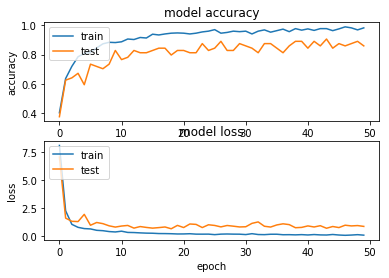

In [10]:
train_FC_model()

In [11]:
def predict(image_path):
    # load the class_indices saved in the earlier step
    class_dictionary = np.load('class_indices.npy').item()

    num_classes = len(class_dictionary)

    #load and pre-process the image
    #orig = cv2.imread(image_path)
    print("[INFO] loading and preprocessing image...")
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)

    # Rescale the image, this is important, otherwise the predictions will be '0'
    # This is because ImageDataGenerator set rescale=1. / 255, 
    # which means all data is re-scaled from a [0 - 255] range to [0 - 1.0]
    image = image / 255
    image = np.expand_dims(image, axis=0)

    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    # get the bottleneck prediction from the pre-trained VGG16 model
    bottleneck_prediction = model.predict(image)

    # build top FC model block
    model = Sequential()
    model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    #model.add(Dense(num_classes, activation='sigmoid'))  # to get class prediction
    model.add(Dense(num_classes, activation='softmax'))   # to get probability prediction
    
    model.load_weights(top_model_weights_path)

    # use the bottleneck prediction on the FC model to get the final classification
    class_predicted = model.predict_classes(bottleneck_prediction)

    #proba = model.predict_proba(bottleneck_prediction)
    
    output_y = model.predict(bottleneck_prediction)

    inID = class_predicted[0]

    inv_map = {v: k for k, v in class_dictionary.items()}

    label = inv_map[inID]

    # get the prediction label
    print("Prediction: class ID: {}, Label: {}".format(inID, label))
    
    #print(proba)
    
    predict1 = {}
    for i in range(len(output_y[0])):
        predict1[inv_map[i]] = output_y[0][i]

    print(predict1)

    print('sum of probability = {0}'.format(sum(output_y[0])))
    
    

    # display the predictions with the image
    '''
    cv2.putText(orig, "Predicted: {}".format(label), (10, 30),
                cv2.FONT_HERSHEY_PLAIN, 1.5, (43, 99, 255), 2)

    cv2.imshow("Classification", orig)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    '''


In [12]:
 # add the path to your test image below
image_path = './data/Document_PNG/validation/Bank Statement/Chase-bank-statement-2.png'
predict(image_path)

#cv2.destroyAllWindows()

[INFO] loading and preprocessing image...
Prediction: class ID: 2, Label: Bank Statement
{'1003': 4.6019258e-11, 'Allonge': 1.074794e-15, 'Bank Statement': 0.9999893, 'Closing Disclosure': 1.0242984e-05, 'Drivers Licence': 5.5398866e-11, 'Initial Escrow Disclosure': 2.5731388e-11, 'Loan Estimate': 6.347503e-11, 'Note': 1.6424876e-09, 'Notice of Servicing Transfer': 2.4302619e-08, 'Other': 3.825096e-12, 'Payment Coupon': 8.2235226e-16, 'Payment Letter': 3.1252334e-13, 'Paystubs': 2.6640052e-07, 'Right to Cancel': 1.7477422e-09, 'Security Instrument': 2.0486551e-10, 'Service Provider Disclosure': 3.120129e-13, 'W2': 2.975415e-07}
sum of probability = 1.000000106182744


In [15]:
image_path = './data/Document_PNG/validation/W2/W2 C-20173-0.PNG'
predict(image_path)

[INFO] loading and preprocessing image...
Prediction: class ID: 16, Label: W2
{'1003': 4.2167032e-13, 'Allonge': 2.1861557e-26, 'Bank Statement': 4.5801533e-11, 'Closing Disclosure': 2.32946e-11, 'Drivers Licence': 1.9603533e-18, 'Initial Escrow Disclosure': 4.61914e-15, 'Loan Estimate': 3.567726e-12, 'Note': 1.7376846e-18, 'Notice of Servicing Transfer': 7.62583e-20, 'Other': 2.117874e-21, 'Payment Coupon': 1.2553912e-23, 'Payment Letter': 2.91536e-20, 'Paystubs': 1.8488071e-14, 'Right to Cancel': 2.6077193e-17, 'Security Instrument': 1.751361e-17, 'Service Provider Disclosure': 1.4223879e-22, 'W2': 1.0}
sum of probability = 1.0000000000731086
